In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
#sys.path.append('/Home/src/jaratest/maxh')
import oddball_analysis_functions as odbl
from jaratoolbox import celldatabase
from jaratoolbox import settings
from jaratoolbox import ephyscore
from jaratoolbox import spikesanalysis
from jaratoolbox import extraplots
from jaratoolbox import behavioranalysis

timeRangePlot = [-0.3, 0.45]
timeRangeStim = [0.015, 0.115]
timeRangeBaseline = [-0.2, 0]
baselineDuration = timeRangeBaseline[1] - timeRangeBaseline[0]
stimDuration = timeRangeStim[1] - timeRangeStim[0]


subject = 'acid006'

inforecFile = os.path.join(settings.INFOREC_PATH, f'{subject}_inforec.py')

celldb = celldatabase.generate_cell_database(inforecFile)
dbPath = os.path.join(settings.DATABASE_PATH ,f'celldb_{subject}.h5')

reagents = ('saline', 'doi')
oddballSessions = ('FM_Up', 'FM_Down')

nCells = len(celldb)

baselineFiringPureTones = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
stimAvgFiringPureTones = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
stimMaxAvgFiringPureTones = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}
stimBestFrequency = {'saline':np.empty(nCells), 'doi':np.empty(nCells)}

for indRow, dbRow in celldb.iterrows():
    oneCell = ephyscore.Cell(dbRow)

    for reagent in reagents:
        sessionType = f'{reagent}PureTones'
    
        ephysData, bdata = oneCell.load(sessionType)  
        spikeTimes = ephysData['spikeTimes']
        eventOnsetTimes = ephysData['events']['stimOn']

        
        frequencies_each_trial = bdata['currentFreq']
        array_of_frequencies = np.unique(bdata['currentFreq'])
        
        # Checks to see if trial count from bdata is the same as trial count from ephys
        if (len(frequencies_each_trial) > len(eventOnsetTimes)) or (len(frequencies_each_trial) < len(eventOnsetTimes)-1):
            print(f'Warning! BevahTrials ({len(frequencies_each_trial)}) and ' + f'EphysTrials ({len(eventOnsetTimes)})')
            sys.exit()

        # If the ephys data is 1 more than the bdata, delete the last ephys trial.
        if len(frequencies_each_trial) == len(eventOnsetTimes)-1:
            eventOnsetTimes = eventOnsetTimes[:len(frequencies_each_trial)]



        
        (spikeTimesFromEventOnset, trialIndexForEachSpike, indexLimitsEachTrial) = spikesanalysis.eventlocked_spiketimes(spikeTimes, eventOnsetTimes, timeRangePlot)

        trialsEachCond = behavioranalysis.find_trials_each_type(frequencies_each_trial, array_of_frequencies)

        spikeCountMatBase = spikesanalysis.spiketimes_to_spikecounts(spikeTimesFromEventOnset, indexLimitsEachTrial, timeRangeBaseline)
        spikeCountMatStim = spikesanalysis.spiketimes_to_spikecounts(spikeTimesFromEventOnset, indexLimitsEachTrial, timeRangeStim)

        baselineFiringPureTones[reagent][indRow] = np.mean(spikeCountMatBase) / baselineDuration

        nTrials = len(indexLimitsEachTrial[0])
        trialsEachCondInds, nTrialsEachCond, nCond= extraplots.trials_each_cond_inds(trialsEachCond, nTrials)

        firingRates = np.empty(nCond)
        for cond in range(trialsEachCond.shape[1]):
            nSpikesEachTrial = spikeCountMatStim[trialsEachCond[:,cond]]
            avgSpikes = np.mean(nSpikesEachTrial)
            spikesFiringRate = (avgSpikes / stimDuration)
            firingRates[cond] = spikesFiringRate
        avgFiringRate = np.mean(firingRates)
        maxAvgFiringRate = firingRates.max()
        bestFreq = array_of_frequencies[np.argmax(firingRates)]


        stimAvgFiringPureTones[reagent][indRow] = avgFiringRate
        stimMaxAvgFiringPureTones[reagent][indRow] = maxAvgFiringRate
        stimBestFrequency[reagent][indRow] = bestFreq
    '''
    for reagent in reagents:
        for session in oddballSessions:
            sessionType = f'{reagent}{session}'
    '''
    for reagent in reagents:
        sessionType = reagent
        spikeTimesFromEventOnsetUp, trialIndexForEachSpikeUp, indexLimitsEachTrialUp, upOdd, downStandard = odbl.main_function(oneCell, f'{sessionType}FM_Up', timeRangePlot)
        spikeTimesFromEventOnsetDown, trialIndexForEachSpikeDown, indexLimitsEachTrialDown, upStandard, downOdd = odbl.main_function(oneCell, f'{sessionType}FM_Down', timeRangePlot)

        trialsBeforeOddDownStd = odbl.trials_before_oddball(upOdd)       
        trialsBeforeOddUpStd = odbl.trials_before_oddball(downOdd)

        spikeCountMatUp = spikesanalysis.spiketimes_to_spikecounts(spikeTimesFromEventOnsetUp, indexLimitsEachTrialUp, timeRangeStim)
        spikeCountMatDown = spikesanalysis.spiketimes_to_spikecounts(spikeTimesFromEventOnsetDown, indexLimitsEachTrialDown, timeRangeStim)

        firingRates = np.empty(nCond)

        upOddSpikes = spikeCountMatUp[upOdd]
        downStandardSpikes = spikeCountMatUp[trialsBeforeOddDownStd]
        downOddSpikes = spikeCountMatDown[downOdd]
        upStandardSpikes = spikeCountMatDown[trialsBeforeOddUpStd]


        for cond in range(trialsEachCond.shape[1]):
            nSpikesEachTrial = spikeCountMatStim[trialsEachCond[:,cond]]
            avgSpikes = np.mean(nSpikesEachTrial)
            spikesFiringRate = (avgSpikes / stimDuration)
            firingRates[cond] = spikesFiringRate
        avgFiringRate = np.mean(firingRates)
        maxAvgFiringRate = firingRates.max()
        bestFreq = array_of_frequencies[np.argmax(firingRates)]


celldb['baselineFiringRatePureTonesSaline'] = baselineFiringPureTones['saline']
celldb['baselineFiringRatePureTonesDOI'] = baselineFiringPureTones['doi']

celldb['stimFiringRatePureTonesSaline'] = stimAvgFiringPureTones['saline']
celldb['stimFiringRatePureTonesDOI'] = stimAvgFiringPureTones['doi']

celldb['stimMaxAvgFiringRatePureTonesSaline'] = stimMaxAvgFiringPureTones['saline']
celldb['stimMaxAvgFiringRatePureTonesDOI'] = stimMaxAvgFiringPureTones['doi']

celldb['stimBestFrequencyPureTonesSaline'] = stimBestFrequency['saline']
celldb['stimBestFrequencyPureTonesDOI'] = stimBestFrequency['doi']



Generating database for /home/jarauser/src/jarainfo/inforecordings/acid006_inforec.py
Adding experiment from acid006 on 2023-03-22


KeyboardInterrupt: 

In [25]:
reagents = ('saline', 'doi')
sessions = ('FM_Up', 'FM_Down')
for reagent in reagents:
        for session in sessions:
            sessionType = f'{reagent}{session}'
            print(sessionType)

salineFM_Up
salineFM_Down
doiFM_Up
doiFM_Down


'\nplt.plot(np.tile(barLoc[0], nCells), celldb[\'baselineFiringRatePureTonesSaline\'].iloc[cellInd], \'o\', color = \'blue\')\nplt.plot(np.tile(barLoc[1], nCells), celldb[\'baselineFiringRatePureTonesDOI\'].iloc[cellInd], \'o\', color = \'red\')\n\n\nfontSize = 16\naxes.set_xlim(barLoc[0] - 0.2, barLoc[1] + 0.2)\naxes.set_xticks(barLoc)\naxes.set_xticklabels([\'saline\', \'DOI\'], fontsize = fontSize)\naxes.set_ylabel("Average Firing Rate/s", fontsize = fontSize)\n#axes.set_ylim()\n\nextraplots.boxoff(axes)\nextraplots.set_ticks_fontsize(axes, 10)\n'

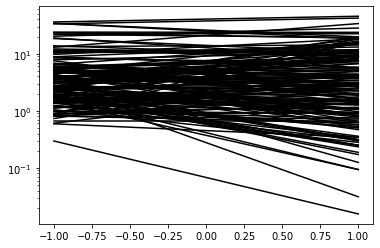

In [36]:
axes = plt.subplot()

barLoc = np.array([-1, 1])


for cellInd in range(nCells):
    plt.plot(barLoc, [celldb['baselineFiringRatePureTonesSaline'].iloc[cellInd], 
             celldb['baselineFiringRatePureTonesDOI'].iloc[cellInd]], '-', color = 'black')

plt.gca().set_yscale('log')

'''
plt.plot(np.tile(barLoc[0], nCells), celldb['baselineFiringRatePureTonesSaline'].iloc[cellInd], 'o', color = 'blue')
plt.plot(np.tile(barLoc[1], nCells), celldb['baselineFiringRatePureTonesDOI'].iloc[cellInd], 'o', color = 'red')


fontSize = 16
axes.set_xlim(barLoc[0] - 0.2, barLoc[1] + 0.2)
axes.set_xticks(barLoc)
axes.set_xticklabels(['saline', 'DOI'], fontsize = fontSize)
axes.set_ylabel("Average Firing Rate/s", fontsize = fontSize)
#axes.set_ylim()

extraplots.boxoff(axes)
extraplots.set_ticks_fontsize(axes, 10)
'''

In [23]:
celldb


,cluster,cluster_label,subject,date,brainArea,recordingTrack,probe,info,pdepth,ephysTime,...,bestChannel,spikeShape,baselineFiringRatePureTonesSaline,baselineFiringRatePureTonesDOI,stimFiringRatePureTonesSaline,stimFiringRatePureTonesDOI,stimMaxAvgFiringRatePureTonesSaline,stimMaxAvgFiringRatePureTonesDOI,stimBestFrequencySaline,stimBestFrequencyDOI
0,8,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,6,"[0.006740101, 0.020853661, 0.018258924, 0.0194...",3.504673,4.361371,2.767857,4.321429,6.500000,8.5,5428.835,40000.000
1,9,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,6,"[-0.00017609342, 0.015997056, 0.012725816, 0.0...",1.401869,0.249221,1.397321,0.278274,2.857143,1.0,9883.543,8094.263
2,10,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,10,"[0.0010515678, 0.017536508, 0.01450617, 0.0158...",1.573209,1.059190,1.459821,0.840774,4.000000,2.0,21971.211,5428.835
3,11,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,10,"[-0.00011609874, 0.021584814, 0.017250448, 0.0...",5.950156,9.034268,4.325893,8.040179,8.000000,11.5,2442.111,2981.952
4,12,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,12,"[0.001497007, 0.014454904, 0.011647023, 0.0123...",5.685358,1.588785,6.434524,1.811012,10.952381,3.5,9883.543,4446.019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,528,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,252,"[0.00028212447, 0.02479439, 0.019956922, 0.021...",1.355140,0.934579,0.812500,0.625000,3.500000,2.0,2981.952,8094.263
155,539,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,56,"[0.000898839, 0.022627773, 0.018621035, 0.0203...",4.828660,2.975078,4.462798,3.177083,7.500000,6.0,14736.126,2442.111
156,541,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,45,"[0.001705938, 0.025331927, 0.021166442, 0.0230...",5.015576,5.109034,5.321429,5.336310,8.500000,9.5,14736.126,4446.019
157,542,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...",...,257,"[-0.0020449723, 0.01075232, 0.0074348934, 0.00...",1.401869,2.445483,0.492560,1.093750,2.380952,3.5,9883.543,2442.111


In [20]:
print(celldb['baselineFiringRatePureTonesSaline'].median())
print(celldb['baselineFiringRatePureTonesDOI'].median())

3.052959501557632
2.8971962616822426


In [4]:
celldb

,cluster,cluster_label,subject,date,brainArea,recordingTrack,probe,info,pdepth,ephysTime,paradigm,behavSuffix,sessionType,maxDepth,egroup,bestChannel,spikeShape,baselineFiringRatePureTonesSaline,baselineFiringRatePureTonesDOI
0,8,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...","[am_tuning_curve, oddball_sequence, oddball_se...","[apre, apre, bpre, cpre, dpre, aduring, asalin...","[prePureTones, preHighFreq, preLowFreq, preFM_...",3000,0,6,"[0.006740101, 0.020853661, 0.018258924, 0.0194...",3.504673,4.361371
1,9,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...","[am_tuning_curve, oddball_sequence, oddball_se...","[apre, apre, bpre, cpre, dpre, aduring, asalin...","[prePureTones, preHighFreq, preLowFreq, preFM_...",3000,0,6,"[-0.00017609342, 0.015997056, 0.012725816, 0.0...",1.401869,0.249221
2,10,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...","[am_tuning_curve, oddball_sequence, oddball_se...","[apre, apre, bpre, cpre, dpre, aduring, asalin...","[prePureTones, preHighFreq, preLowFreq, preFM_...",3000,0,10,"[0.0010515678, 0.017536508, 0.01450617, 0.0158...",1.573209,1.059190
3,11,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...","[am_tuning_curve, oddball_sequence, oddball_se...","[apre, apre, bpre, cpre, dpre, aduring, asalin...","[prePureTones, preHighFreq, preLowFreq, preFM_...",3000,0,10,"[-0.00011609874, 0.021584814, 0.017250448, 0.0...",5.950156,9.034268
4,12,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...","[am_tuning_curve, oddball_sequence, oddball_se...","[apre, apre, bpre, cpre, dpre, aduring, asalin...","[prePureTones, preHighFreq, preLowFreq, preFM_...",3000,0,12,"[0.001497007, 0.014454904, 0.011647023, 0.0123...",5.685358,1.588785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,528,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...","[am_tuning_curve, oddball_sequence, oddball_se...","[apre, apre, bpre, cpre, dpre, aduring, asalin...","[prePureTones, preHighFreq, preLowFreq, preFM_...",3000,0,252,"[0.00028212447, 0.02479439, 0.019956922, 0.021...",1.355140,0.934579
155,539,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...","[am_tuning_curve, oddball_sequence, oddball_se...","[apre, apre, bpre, cpre, dpre, aduring, asalin...","[prePureTones, preHighFreq, preLowFreq, preFM_...",3000,0,56,"[0.000898839, 0.022627773, 0.018621035, 0.0203...",4.828660,2.975078
156,541,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...","[am_tuning_curve, oddball_sequence, oddball_se...","[apre, apre, bpre, cpre, dpre, aduring, asalin...","[prePureTones, preHighFreq, preLowFreq, preFM_...",3000,0,45,"[0.001705938, 0.025331927, 0.021166442, 0.0230...",5.015576,5.109034
157,542,good,acid006,2023-03-22,AC_right,???,NPv1-9691,"[faces ???, soundLeft]",3000,"[13-51-20, 13-59-56, 14-05-37, 14-11-25, 14-17...","[am_tuning_curve, oddball_sequence, oddball_se...","[apre, apre, bpre, cpre, dpre, aduring, asalin...","[prePureTones, preHighFreq, preLowFreq, preFM_...",3000,0,257,"[-0.0020449723, 0.01075232, 0.0074348934, 0.00...",1.401869,2.445483
